In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.datasets import make_circles
from sklearn.ensemble import RandomTreesEmbedding, ExtraTreesClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import BernoulliNB
import pickle
from sklearn.externals import joblib

In [15]:
import pandas as pd
import os 
print(os.getcwd())
data = pd.read_csv('../S3DIOstats.txt', delim_whitespace=True)
data = data.sample(frac=1).reset_index(drop=True)
modelfile = 'final.sav'
projectdir = "/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/"


array = data.values

print(data.head())
print(data.shape)
data.columns=['col1','col2','col3','col4','col5','col6','col7','col8','col9','col10','col11','col12','col13','col14','col15','col16','col17']
z = data['col2'].str.split('-')
print(z.head())
data['col13']=data['col13'].eq("enable").mul(1)
data['col14']=data['col14'].eq("enable").mul(1)
data['col15']=data['col15'].eq("enable").mul(1)
data['col16']=data['col16'].eq("enable").mul(1)

/home/dsinghvi/sem8/parallel/project/CS633-2018-19-2-project/progress/active
   S3D-IO    50-50-100-2-2-4-1   526.27   0.03  0.06   66.03   0.15    2.31  \
0  S3D-IO  400-400-800-4-4-8-1  1870.47  15.26  8.35  439.62  45.78  106.63   
1  S3D-IO  200-200-400-4-4-4-1   971.61   1.91  2.01  660.25   5.72    8.87   
2  S3D-IO   50-100-100-2-2-4-1    89.51   0.06  0.68  142.33   0.30    2.14   
3  S3D-IO  100-400-400-2-4-4-1   977.33   1.91  2.00  783.88   5.72    7.47   
4  S3D-IO  100-100-200-2-4-4-1  1060.04   0.24  0.23  863.04   0.72    0.85   

   0.05  0.01    196608  12   enable enable.1 enable.2  disable  478150656  
0  0.11  0.08     65536  18   enable  disable   enable  disable   23068672  
1  0.73  0.14  19529728   2  disable  disable   enable   enable  515899392  
2  0.07  0.02    851968  14   enable  disable   enable  disable  634388480  
3  0.05  0.19  14680064  10  disable  disable   enable  disable  519045120  
4  0.05  0.05  22085632  10   enable  disable   enable  disable

In [16]:
##### FEATURES for our model(some could be specific to the benchmark)

X_temp = pd.DataFrame() #creates a new dataframe that's empty
X = pd.DataFrame(z.tolist())
X = X.drop(6, 1)

#MPI AND LUSTURE HINTS ADDED AS FEATURES
X_temp['cb1']=data['col11']
X_temp['cb2']=data['col12']
#X['cb3']=data['col13']
#X['cb4']=data['col14']
#X['cb5']=data['col15']
#X['cb6']=data['col16']
X_temp['cb7']=data['col17']

X =pd.concat([X, X_temp], axis=1)

#RATIO added as feature to give size of box each process needs to take(specific to S3D-IO)
X['ratio1'] = X.iloc[:,0].astype(int)/(X.iloc[:,3].astype(int)*100)
X['ratio2'] = X.iloc[:,1].astype(int)/(X.iloc[:,4].astype(int)*100)
X['ratio3'] = X.iloc[:,2].astype(int)/(X.iloc[:,5].astype(int)*100)

###NORMALIZING 
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X.values)
X = pd.DataFrame(X_scaled)
print(type(X))
print(X.head())
i=0

for _ in X.columns:
    if(i == 0):
        continue
    X.iloc[:,i].astype(int)
    print(i)
    i=i+1 

#pd.options.display.max_rows=  1500
#print(X.iloc[:,0])



<class 'pandas.core.frame.DataFrame'>
         0         1         2    3    4         5         6         7   \
0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  0.000055  0.037113   
1  0.428571  0.428571  0.466667  1.0  1.0  0.333333  0.016310  0.004124   
2  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000712  0.028866   
3  0.142857  1.000000  0.466667  0.0  1.0  0.333333  0.012260  0.020619   
4  0.142857  0.142857  0.200000  0.0  1.0  0.333333  0.018445  0.020619   

         8         9         10        11  
0  0.020608  0.428571  0.428571  0.428571  
1  0.481845  0.142857  0.142857  0.428571  
2  0.592738  0.000000  0.142857  0.000000  
3  0.484789  0.142857  0.428571  0.428571  
4  0.240432  0.142857  0.000000  0.142857  


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [17]:
Y = data['col6'] ### WRITE BANDWIDTH
Y=Y.values
Y = Y*100
Y = Y.astype(int)


#### SPLITTING INTO TEST -TRAIN DATASET
msk = np.random.rand(len(X)) < 0.8
train_X = X[msk]
test_X = X[~msk]
train_Y = Y[msk]
test_Y = Y[~msk]
print(type(train_X))

y = train_Y
X = train_X

print(X[0:5])
print(type(X))

print(y.shape, X.shape)
print(y[0:5])



<class 'pandas.core.frame.DataFrame'>
         0         1         2    3    4         5         6         7   \
0  1.000000  1.000000  1.000000  1.0  1.0  1.000000  0.000055  0.037113   
1  0.428571  0.428571  0.466667  1.0  1.0  0.333333  0.016310  0.004124   
2  0.000000  0.142857  0.066667  0.0  0.0  0.333333  0.000712  0.028866   
3  0.142857  1.000000  0.466667  0.0  1.0  0.333333  0.012260  0.020619   
4  0.142857  0.142857  0.200000  0.0  1.0  0.333333  0.018445  0.020619   

         8         9         10        11  
0  0.020608  0.428571  0.428571  0.428571  
1  0.481845  0.142857  0.142857  0.428571  
2  0.592738  0.000000  0.142857  0.000000  
3  0.484789  0.142857  0.428571  0.428571  
4  0.240432  0.142857  0.000000  0.142857  
<class 'pandas.core.frame.DataFrame'>
(915,) (915, 12)
[43962 66025 14233 78388 86304]


In [18]:
hasher = RandomTreesEmbedding(n_estimators=10, random_state=0, max_depth=3)
X_transformed = hasher.fit_transform(X)
X_transformed

<915x75 sparse matrix of type '<class 'numpy.float64'>'
	with 9150 stored elements in Compressed Sparse Row format>

In [19]:
svd = TruncatedSVD(n_components=2)
X_reduced = svd.fit_transform(X_transformed)


In [20]:
nb = BernoulliNB()
nb.fit(X_transformed, y)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [21]:
trees = ExtraTreesClassifier(max_depth=100, n_estimators=300, random_state=0)
trees.fit(X, y)



ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=100, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
print(test_X.head(1))
print(test_X.shape)
trees.predict(test_X.head(1))

         0         1         2    3    4         5         6         7   \
5  0.428571  0.428571  0.466667  1.0  1.0  0.333333  0.012534  0.008247   

         8         9         10        11  
5  0.160942  0.142857  0.142857  0.428571  
(220, 12)


array([52814])

In [23]:
predicted = trees.predict(test_X)
#print(test_Y)
from sklearn.metrics import r2_score
r2_score(test_Y,predicted)

0.7181167428351016

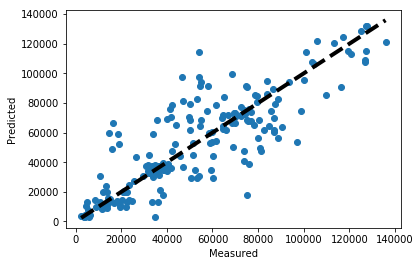

In [26]:
fig, ax = plt.subplots()
ax.scatter(test_Y, predicted)
ax.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.savefig("etrresult.png")
plt.show()

In [ ]:
# save the model to disk

modelfile = 'final.sav'
pickle.dump(trees, open(modelfile, 'wb'))
scaler_filename = "scaler.save"
joblib.dump(min_max_scaler, scaler_filename) 


In [ ]:
# import json
# with open(projectdir+'confex.json') as f:
#     data = json.load(f)

# romio_ds_read = data["mpi"]["romio_ds_read"]
# romio_ds_write = data["mpi"]["romio_ds_write"]
# romio_cb_read = data["mpi"]["romio_cb_read"]
# romio_cb_write = data["mpi"]["romio_cb_write"]
# cb_buffer_size = data["mpi"]["cb_buffer_size"]
# stripe_size = data["lfs"]["setstripe"]["size"]
# stripe_count = data["lfs"]["setstripe"]["count"]

# col_names =  ['cb1', 'cb2', 'cb5','cb6','cb7']
# cb_df  = pd.DataFrame(columns = col_names)
# cb_df.loc[len(cb_df)] = [romio_ds_read,romio_ds_write,stripe_size, stripe_count, cb_buffer_size]


# scaler_filename = "scaler.save"
# scaler = joblib.load(scaler_filename) 
# norm_df = scaler.transform( cb_df )
# temp = pd.DataFrame(norm_df)




# col_names =  ['0','1', '2','3','4','5','6','7','8','9','10']
# my_df = pd.DataFrame(columns=col_names)
# my_df.loc[len(my_df)] = [100,100,100,2,2,4]
# x = pd.concat([my_df,temp], axis=1)


# print(trees.predict(x))

In [ ]:
# print(predicted)

In [ ]:
# x


In [ ]:
# test_X.head(1)

In [ ]:
# trees.predict(test_X.head(1))